In [18]:
from openai import OpenAI
import pandas as pd 
import json
import duckdb
from pydantic import BaseModel, Field
from IPython.display import Markdown
import seaborn as sns

In [19]:
from dotenv import load_dotenv
import os
load_dotenv()
api_key = os.getenv("OPEN_API_KEY")
client=OpenAI(api_key=api_key)

model='gpt-4o-mini'

In [20]:
transaction_path='/home/toan999/coding/Agent/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [21]:
SQL_GENERATE_PROMPT="""
Generate a SQL to access duckdb based on the prompt. Do not reply anything beside the query. 
The prompt is {prompt}.

The table name is {table_name}.
The available columns are {column}.
"""

In [22]:
def generate_sql_query(prompt: str, column: list, table_name: str) ->str:
    """Generate a SQL query based on the prompt"""
    formatted_prompt=SQL_GENERATE_PROMPT.format(prompt=prompt, column=column, table_name=table_name)
    completion = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": formatted_prompt
            }
        ]
    )
    return completion.choices[0].message.content

In [73]:
@tracer.tool()
def sale_lookup(prompt):
    try:
        # db creation
        df = pd.read_parquet(transaction_path)
        table_name='sales'
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * from df")
        
        # query generation
        sql_generated=generate_sql_query(prompt, df.columns,table_name)
        sql_final=sql_generated.replace('```sql', '').replace('```','').strip()

        with tracer.start_as_current_span(
            "execute_sql_query",openinference_span_kind="chain"
        ) as span:
            span.set_input(value=sql_final)
        # query execution
            result=duckdb.sql(sql_final).df()
            span.set_output(value=str(result))
            span.set_status(StatusCode.OK)
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data {str(e)}"

In [24]:
exam_data=sale_lookup('Show me 20 sales of the store with highest number')
exam_data

'    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo\n0           2970    6172800               22875 2021-11-21         2         37.900002         0\n1           2970    6172800               22875 2022-04-29         1         18.950001         0\n2           2970    6172800               22875 2022-07-20         1         18.950001         0\n3           2970    6172800               22875 2022-08-27         1         18.950001         0\n4           2970    6172800               22875 2022-12-17         1         18.950001         0\n5           2970    6172800               22875 2023-02-02         1         18.950001         0\n6           2970    6172800               22875 2023-03-22         4         75.800003         0\n7           2970    6172800               22875 2023-04-29         3         56.849998         0\n8           2970    6172800               22875 2023-05-07         1         18.950001         0\n9           2970   

In [25]:
analysis_prompt="""
Based on provided data {data}, help to answer the needs from {prompt}.

Let make analysis to recommend for the growth manager to take immediate action
"""

In [70]:
@tracer.tool()
def sale_analysis(prompt: str, data: str):
    """Generate data analysis prompt"""
    prompt_final=analysis_prompt.format(data=data, prompt=prompt)
    completion=client.chat.completions.create(
        model=model,
        messages=[
            {
                "role":"user",
                "content":prompt_final
            }
        ]
    )
    analysis=completion.choices[0].message.content
    return analysis if analysis else "No info here"

In [27]:
insight=sale_analysis('what is its performance?', exam_data)

In [28]:
Markdown(insight)

To analyze the performance of the sales data provided, we can consider several dimensions, such as total sales over time, trends in quantities sold, seasonality, and the impact of promotional activities (even though all entries in the "On_Promo" column are marked as 0). Here’s a detailed analysis based on the data you've provided.

### 1. Total Sales Performance:
**SKU 6172800**: 
- **Total Quantity Sold**: 17 units 
- **Total Sale Value**: $367.80
- **Sales by Year**:
  - **2021**: 2 units (1 sale)
  - **2022**: 6 units (5 sales)
  - **2023**: 9 units (7 sales)
  - **2024**: 2 units (2 sales, future dates included)

**SKU 6172850**: 
- **Total Quantity Sold**: 8 units 
- **Total Sale Value**: $159.90
- **Sales by Year**:
  - **2021**: 1 unit (1 sale)
  - **2022**: 7 units (4 sales, with two sales of 2 units on June 12)

### 2. Trend Analysis:
- **Volume Trend**: Sales appear to increase over time for SKU 6172800, with peaks on specific dates (notably in March 2023), suggesting growing customer interest or improved stock availability.
- For SKU 6172850, sales are more sporadic with a noticeable increase in June 2022.

### 3. Monthly/Seasonal Trends:
- **SKU 6172800** shows consistent movement every few months but there are spikes in March (4 units) and April (3 units) of 2023.
- **SKU 6172850** showed better sales activity in June as well.

### 4. Recommendations for Growth Manager:
Based on the observed trends and performance data, here are some recommended actions:

1. **Promotional Strategy**:
   - **Targeted Promotions**: Introduce promotions during peak months (such as March and June) as these periods can significantly increase sales. Since the current data shows no promotional activity, integrating it into the strategy may help boost sales.
   - **Bundling Products**: Combine SKU 6172800 and 6172850 in promotional offers together, as they belong to the same class and might attract more customers together.

2. **Inventory Management**:
   - **Levels of Stock**: Ensure that stock levels are maintained for high-selling products during peak times to prevent lost sales due to stockouts.
   - **Forecasting**: Use past sales data to better forecast future demands—especially around specific months where spikes have been noticed.

3. **Market Research**:
   - **Customer Feedback**: Investigate customer feedback for these SKUs to identify any barriers to higher sales, and address any common concerns that prevent sales (e.g., product visibility, product fit in the market).
   - **Competitive Analysis**: Assess the market and analyze whether competitors are offering similar products and how their promotions are structured. 

4. **Diversification**:
   - **Introduce New Variants**: If these SKUs are successful, there could be opportunities to introduce related products that leverage the existing customer base.
   - **Cross-Selling**: Encourage cross-selling of related products that are complementary to increase the average transaction size.

5. **Monitor Performance**:
   - Implement a systematic way to monitor sales trends and promotional impacts continuously, adjusting the strategy dynamically based on real-time data.

### Conclusion:
There is a potential for growth for both SKUs, with specific recommended actions focused on promotions, inventory management, customer engagement, and ongoing monitoring of sales trends. Using data-driven strategies will help maximize sales opportunities for both SKUs and enhance overall store performance.

In [29]:
chart_config_prompt="""
Create chart configs to visualize following data 
{data}
The visualization goal is {visualization_goal}
"""

In [30]:
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [67]:
@tracer.chain()
def extract_chart_config(visualization_goal:str, data:str):
    """generate config from prompt"""
    prompt_final=chart_config_prompt.format(data=data, visualization_goal=visualization_goal)

    response=client.beta.chat.completions.parse(
        model=model,
        messages=[
            {
                "role":"user",
                "content":prompt_final
            }
        ],
        response_format=VisualizationConfig,
    )

    try:
        result=response.choices[0].message.content

        return {
            "chart_type": result.chart_type,
            "x_axis": result.x_axis,
            "y_axis": result.y_axis,
            "title": result.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line",
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [32]:
create_chart_prompt="""
From the follow config 
{chart_config}

Write executable python code to create a chart. Just return codes, no other text.
"""

In [68]:
@tracer.chain()
def create_chart(config:str):
    prompt_final=create_chart_prompt.format(chart_config=config)
    response=client.chat.completions.create(
        model=model,
        messages=[
            {
                "role":"user",
                "content":prompt_final
            }
        ],
    )
    result=response.choices[0].message.content
    code=result.replace('```python','').replace('```','').strip()
    return code

In [69]:
@tracer.tool()
def generate_visualization(visualization_goal, data):
    config=extract_chart_config(visualization_goal, data)
    code=create_chart(config)
    return code

In [35]:
smp_data=sale_lookup('Show me 20 sales of the store with highest number')
print(smp_data)

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           2970    6178100               22800 2022-10-16         1          4.990000         0
1           2970    6178100               22800 2022-10-18         6         29.940001         0
2           2970    6178100               22800 2022-10-19         1          4.990000         0
3           2970    6178100               22800 2022-10-20         1          4.990000         0
4           2970    6178100               22800 2022-10-21         1          4.990000         0
5           2970    6178100               22800 2022-10-22         4         19.959999         0
6           2970    6178100               22800 2022-10-23         1          4.990000         0
7           2970    6178100               22800 2022-10-24         2          9.980000         0
8           2970    6178100               22800 2022-10-25         1          4.990000         0
9           2970    6178100   

In [36]:
chart_code=generate_visualization('a chart of sale by product SKU. Put the product SKU on x axis and sum of sale on the y axis', smp_data)

In [37]:
print(chart_code)

import pandas as pd
import matplotlib.pyplot as plt

# Sample data as a string
data = """Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
2970,6178100,22800,2022-10-16,1,4.990000,0
2970,6178100,22800,2022-10-18,6,29.940001,0
2970,6178100,22800,2022-10-19,1,4.990000,0
2970,6178100,22800,2022-10-20,1,4.990000,0
2970,6178100,22800,2022-10-21,1,4.990000,0
2970,6178100,22800,2022-10-22,4,19.959999,0
2970,6178100,22800,2022-10-23,1,4.990000,0
2970,6178100,22800,2022-10-24,2,9.980000,0
2970,6178100,22800,2022-10-25,1,4.990000,0
2970,6178100,22800,2022-10-26,1,4.990000,0
2970,6178100,22800,2022-11-03,1,4.990000,0
2970,6178100,22800,2022-11-05,2,9.980000,0
2970,6178100,22800,2022-11-08,3,14.970000,0
2970,6178100,22800,2022-11-09,1,4.990000,0
2970,6178100,22800,2022-11-12,2,9.980000,0
2970,6178100,22800,2022-11-14,2,9.980000,0
2970,6178100,22800,2022-11-16,1,4.990000,0
2970,6178100,22800,2022-11-19,1,4.990000,0
2970,6178100,22800,2022-11-20,1,4.990000,0
2970

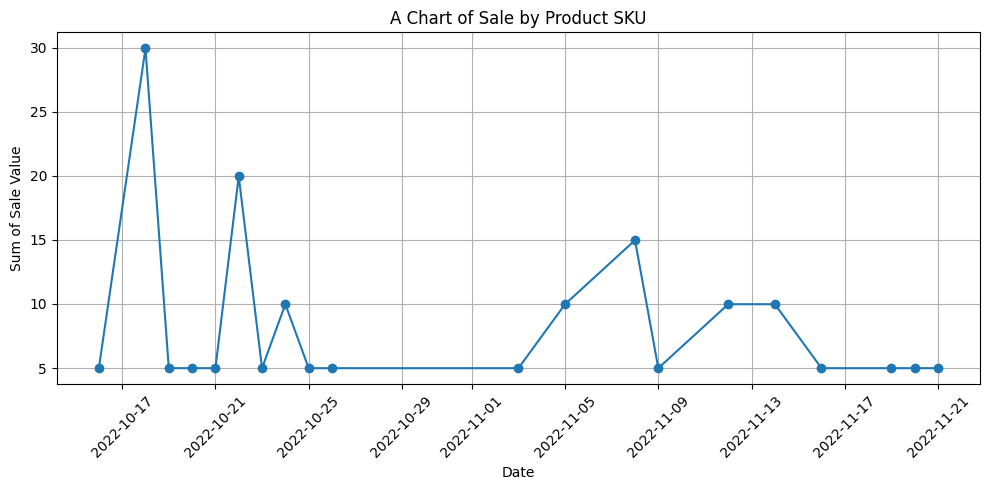

In [38]:
exec(chart_code)

In [39]:
tools = [{
    "type": "function",
    "function": {
        "name": "sale_lookup",
        "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
        "parameters": {
            "type": "object",
            "properties": {
                "prompt": {
                    "type": "string",
                    "description": "The unchanged prompt users provided"
                }
            },
            "required": ["prompt"]
        }
    }
},
    {
    "type": "function",
    "function": {
        "name": "sale_analysis",
        "description": "Analyze sales data to extract insights",
        "parameters": {
            "type": "object",
            "properties": {
                "data": {"type": "string", "description": "The output from sale_lookup tool"},
                "prompt":{"type":"string", "description": "The unchanged prompt users provided"}
            },
            "required": ["data", "prompt"]
        }
    }
    },
    {
    "type": "function",
    "function": {
        "name": "generate_visualization",
        "description": "Generate Python code to create data visualizations",
        "parameters": {
            "type": "object",
            "properties": {
                "data": {"type": "string", "description": "The output from sale_lookup tool"},
                "visualization_goal":{"type":"string", "description": "The goal of visualization"}
            },
            "required": ["prompt", "visualization_goal"]
        }
    }
}]

In [40]:
tool_implementation={
    "sale_lookup": sale_lookup,
    "sale_analysis": sale_analysis,
    "generate_visualization": generate_visualization
}

In [41]:
SYSTEM_PROMPT="You are a helpfull assistant to help users understand insights from this dataset"

In [65]:
@tracer.chain()
def handle_tool_calls(tool_calls, message):
    for tool in tool_calls:
        function=tool_implementation[tool.function.name]
        args=json.loads(tool.function.arguments)
        result=function(**args)
        message.append({"role":"tool", "content":result, "tool_call_id": tool.id})
        return message

In [64]:
def run_agent(messages):
    print(f"Running agent with messages:{messages}")

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)


    while True:
        # Router Span
        print("Making router call to OpenAI")
        with tracer.start_as_current_span(
            "router_call", openinference_span_kind='chain'
        ) as span:
            span.set_input(value=messages)
            response=client.chat.completions.create(
                model=model,
                messages=messages,
                tools=tools,
            )
    
            messages.append(response.choices[0].message)
            tool_calls=response.choices[0].message.tool_calls
            if tool_calls:
                span.set_status(StatusCode.OK)
                print(f"Received response with tool calls: {tool_calls[0].function.name} and {tool_calls[0].id}")
                print("Processing tool calls")
                messages=handle_tool_calls(tool_calls, messages)
                span.set_output(value=tool_calls)
    
            else:
                print("No tool calls, returning final response")
                span.set_output(value=response.choices[0].message.content)
                return response.choices[0].message.content

In [60]:
result = run_agent('Show me the code for graph of sales by store in Dec 2021, and make analysis.')

Running agent with messages:Show me the code for graph of sales by store in Dec 2021, and make analysis.
Making router call to OpenAI
Received response with tool calls: sale_lookup and call_cD97hV67Qut80ABM4UDL8uXg
Processing tool calls
Making router call to OpenAI
Received response with tool calls: sale_analysis and call_mz41BOZRIkIGdsZY7ykBz7Un
Processing tool calls
Making router call to OpenAI
Received response with tool calls: generate_visualization and call_4FoeqOIC2pI1NfWZLbr1Vtfb
Processing tool calls
Making router call to OpenAI
No tool calls, returning final response


In [61]:
Markdown(result)

Here is the code for generating a bar graph of sales by store for December 2021:

```python
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Store_Number': [1540, 4840, 3080, 1320, 4070, 4730, 2090, 2640, 330, 1210, 1760, 2750, 1980, 4400, 2530, 3740, 2970, 1650, 880, 4180, 550, 3630, 2200, 1870, 2310, 3410, 990, 660, 2420, 770, 1100, 3190, 3300],
    'Total_Qty_Sold': [3116.0, 2724.0, 2676.0, 2892.0, 1828.0, 1654.0, 2134.0, 1647.0, 1925.0, 2583.0, 2658.0, 2951.0, 1776.0, 292.0, 1862.0, 2244.0, 3555.0, 2903.0, 2353.0, 1875.0, 1301.0, 2342.0, 2692.0, 2668.0, 2521.0, 2227.0, 2118.0, 2141.0, 2550.0, 1684.0, 2564.0, 2003.0, 3265.0],
    'Total_Sale_Value': [37569.329945, 29933.489884, 32659.609960, 32853.569915, 21321.059979, 18747.209966, 23003.409946, 20872.250000, 21555.029918, 34413.949924, 30765.979889, 35648.789999, 17433.159965, 6061.750041, 20844.890021, 26977.429915, 53453.759857, 38965.520022, 31668.100037, 21071.019946, 16161.550002, 29063.319957, 34780.070020, 30694.519899, 28763.669892, 26714.789922, 24713.900014, 22993.589873, 26545.169849, 17978.159951, 33196.209952, 24083.250015, 39474.609946]
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
plt.bar(df['Store_Number'].astype(str), df['Total_Sale_Value'], color='skyblue')
plt.title('Sales by Store for December 2021')
plt.xlabel('Store Number')
plt.ylabel('Total Sale Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
```

### Analysis Summary:
- The analysis of sales data by store in December 2021 reveals significant insights into the performance of each store. 
- The sales value and quantity sold vary widely across stores, indicating differing levels of customer demand, inventory management, or marketing effectiveness.
- Recommendations target underperforming stores for improvement while seeking to replicate the success of top performers.

Feel free to run this code in a Python environment with the required libraries (`pandas` and `matplotlib`) installed to visualize the sales data further!

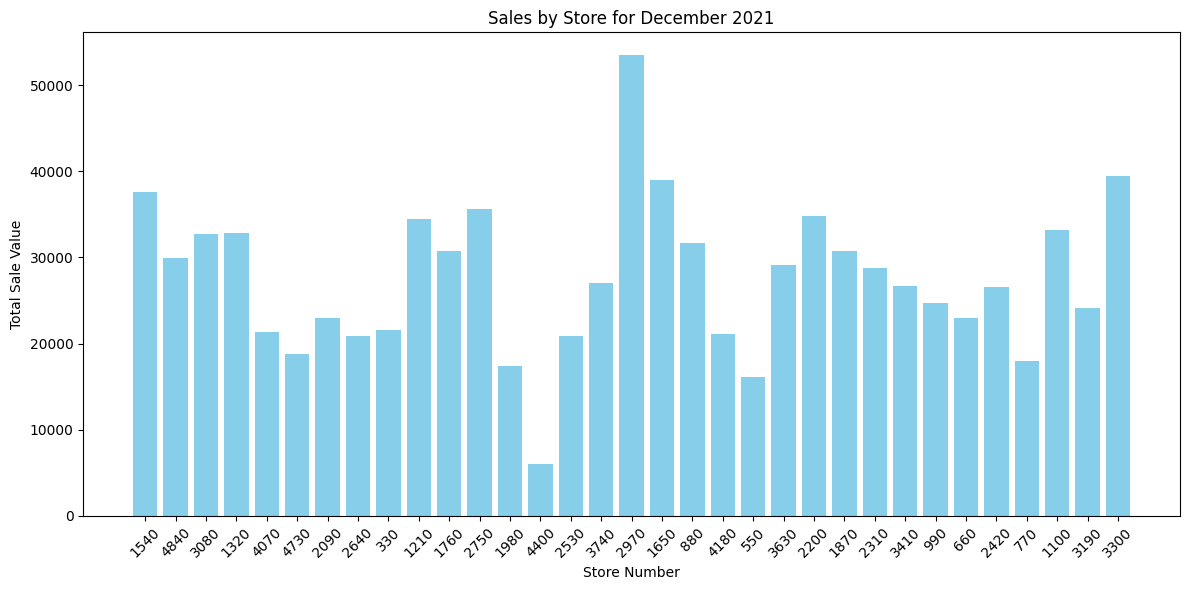

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Store_Number': [1540, 4840, 3080, 1320, 4070, 4730, 2090, 2640, 330, 1210, 1760, 2750, 1980, 4400, 2530, 3740, 2970, 1650, 880, 4180, 550, 3630, 2200, 1870, 2310, 3410, 990, 660, 2420, 770, 1100, 3190, 3300],
    'Total_Qty_Sold': [3116.0, 2724.0, 2676.0, 2892.0, 1828.0, 1654.0, 2134.0, 1647.0, 1925.0, 2583.0, 2658.0, 2951.0, 1776.0, 292.0, 1862.0, 2244.0, 3555.0, 2903.0, 2353.0, 1875.0, 1301.0, 2342.0, 2692.0, 2668.0, 2521.0, 2227.0, 2118.0, 2141.0, 2550.0, 1684.0, 2564.0, 2003.0, 3265.0],
    'Total_Sale_Value': [37569.329945, 29933.489884, 32659.609960, 32853.569915, 21321.059979, 18747.209966, 23003.409946, 20872.250000, 21555.029918, 34413.949924, 30765.979889, 35648.789999, 17433.159965, 6061.750041, 20844.890021, 26977.429915, 53453.759857, 38965.520022, 31668.100037, 21071.019946, 16161.550002, 29063.319957, 34780.070020, 30694.519899, 28763.669892, 26714.789922, 24713.900014, 22993.589873, 26545.169849, 17978.159951, 33196.209952, 24083.250015, 39474.609946]
}

df = pd.DataFrame(data)

plt.figure(figsize=(12, 6))
plt.bar(df['Store_Number'].astype(str), df['Total_Sale_Value'], color='skyblue')
plt.title('Sales by Store for December 2021')
plt.xlabel('Store Number')
plt.ylabel('Total Sale Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [48]:
import phoenix as px
from phoenix.otel import register
from openinference.instrumentation.openai import OpenAIInstrumentor
from openinference.semconv.trace import SpanAttributes
from opentelemetry.trace import Status, StatusCode
from openinference.instrumentation import TracerProvider

In [50]:
sessions=px.launch_app()

Existing running Phoenix instance detected! Shutting it down and starting a new instance...


🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix


In [51]:
project_name="tracing-agent"

In [52]:
tracer_provider=register(
    project_name=project_name,
    endpoint = "http://localhost:6006/v1/traces",
    set_global_tracer_provider=False
)

🔭 OpenTelemetry Tracing Details 🔭
|  Phoenix Project: tracing-agent
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: http://localhost:6006/v1/traces
|  Transport: HTTP + protobuf
|  Transport Headers: {}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.



In [53]:
# OpenAIInstrumentor().instrument(tracer_provider = tracer_provider)
OpenAIInstrumentor().instrument(tracer_provider = tracer_provider)
tracer = tracer_provider.get_tracer(__name__)

Attempting to instrument while already instrumented


In [54]:
def start_main_span(messages):
    print(f"Starting main span with messages: {messages}")

    with tracer.start_as_current_span(
        "AgentRun", openinference_span_kind="agent"
    ) as span:
        span.set_input(value=messages)
        ret = run_agent(messages)
        print(f"Main span run completed with value: {ret}")
        span.set_output(value=ret)
        span.set_status(StatusCode.OK)
        return ret

In [74]:
result = start_main_span([{"role": "user", 
                           "content": "Which stores did the best in 2021?"}])

Starting main span with messages: [{'role': 'user', 'content': 'Which stores did the best in 2021?'}]
Running agent with messages:[{'role': 'user', 'content': 'Which stores did the best in 2021?'}]
Making router call to OpenAI
Received response with tool calls: sale_lookup and call_JjT4SjhTgf0imYbgqLLzROUh
Processing tool calls
Making router call to OpenAI
No tool calls, returning final response
Main span run completed with value: In 2021, the stores that performed the best in terms of total sales are as follows:

1. **Store 2970**: $84,454.33
2. **Store 3300**: $63,205.33
3. **Store 1650**: $62,152.43
4. **Store 1540**: $58,777.02
5. **Store 1210**: $55,435.62
6. **Store 1100**: $52,494.89
7. **Store 1320**: $52,407.36
8. **Store 2750**: $51,959.20
9. **Store 2200**: $51,634.51
10. **Store 3080**: $50,704.06

These stores had the highest total sales in 2021.
